# Get cross-correlations after running adaptive localization using the poly-case

Note that you first need to run ert with ES-MDA and localization turned on.

In [1]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from ert.config import ErtConfig
from ert.storage import open_storage

## Load data frame by using API endpoint

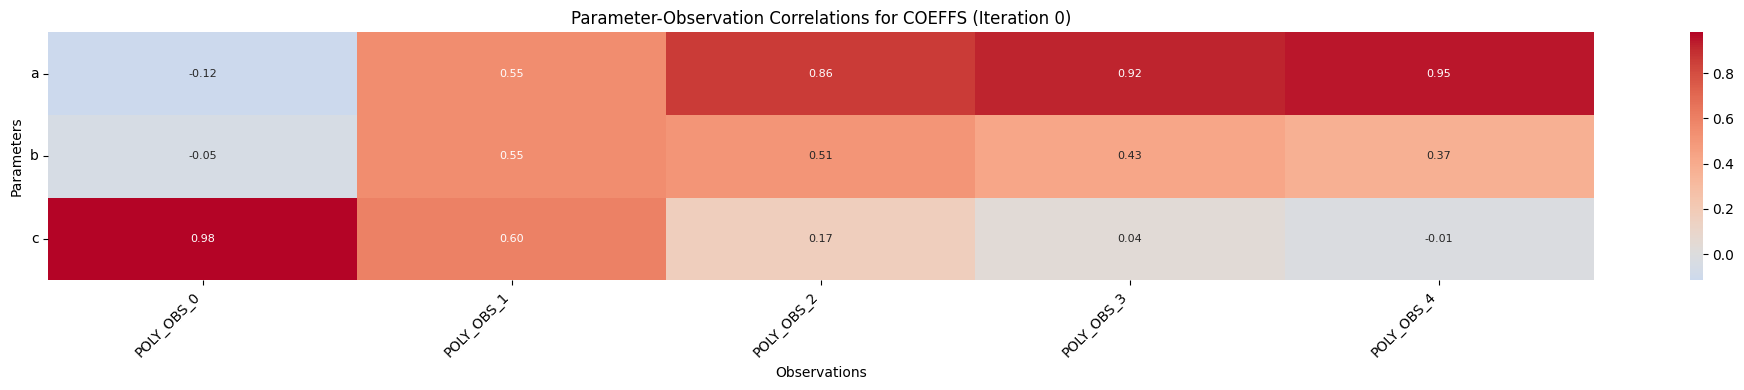

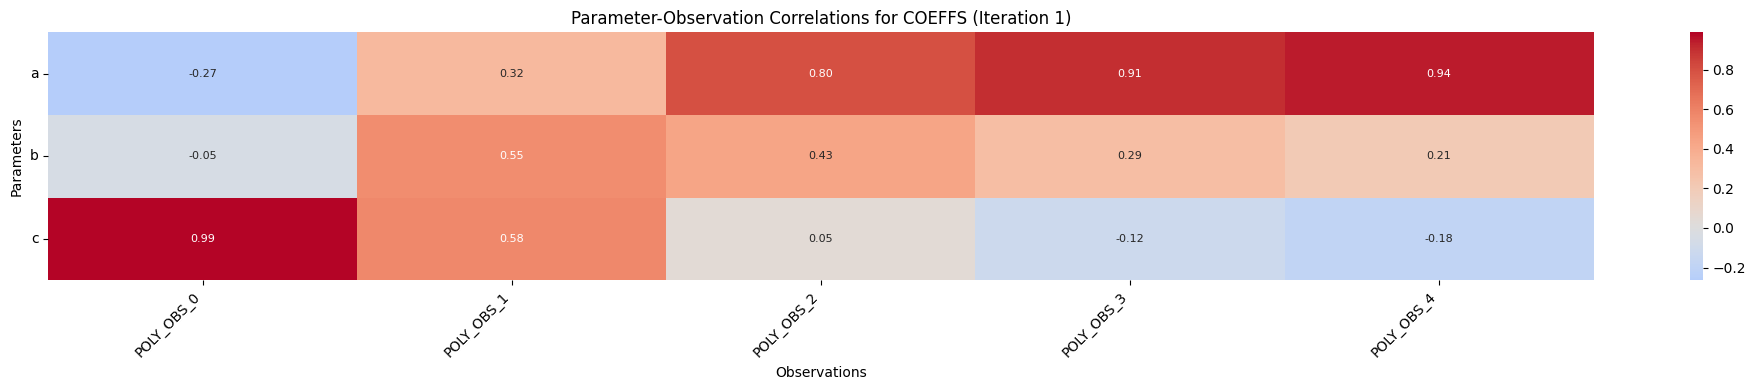

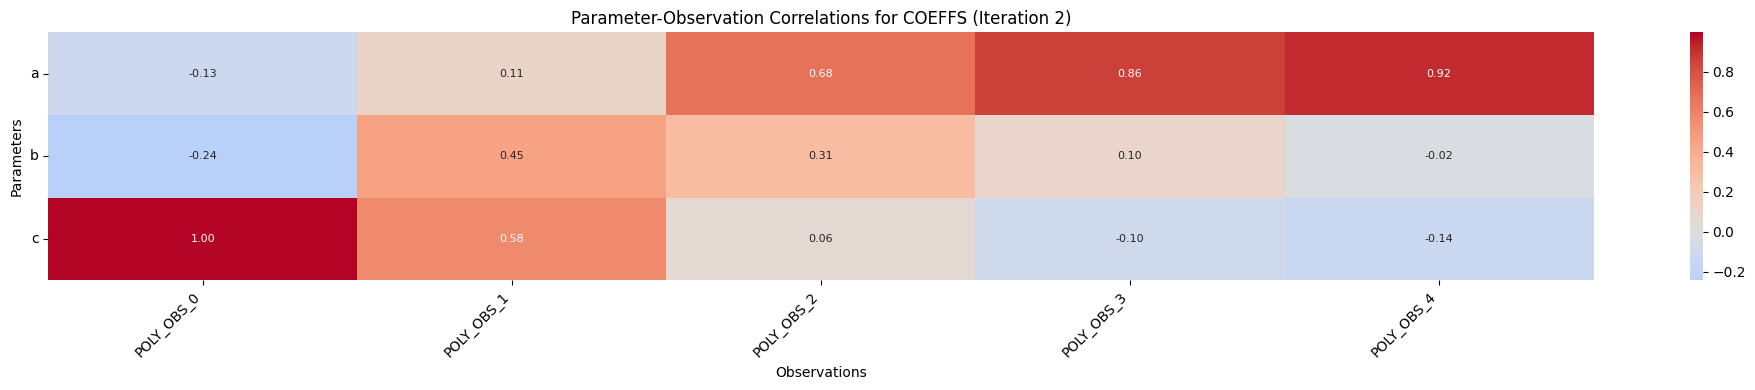

In [3]:
ert_config = ErtConfig.from_file("poly.ert")
# Load data for multiple iterations
iterations = [0, 1, 2]
dfs = []
for iter_num in iterations:
    with open_storage(ert_config.ens_path, mode="r") as storage:
        experiment = storage.get_experiment_by_name("es_mda")
        ensemble = experiment.get_ensemble_by_name(f"default_{iter_num}")
        df = ensemble.load_cross_correlations()
        df = df.with_columns(pl.lit(iter_num).alias("iteration"))
        dfs.append(df)

# Combine all dataframes
df = pl.concat(dfs)

# Get unique parameter groups
param_groups = df["param_group"].unique().to_list()

# Process each parameter group
for group in param_groups:
    # Process each iteration for this group
    for iter_num in iterations:
        iter_df = df.filter(pl.col("iteration") == iter_num)

        pivot_df = iter_df.pivot(
            index=["param_group", "param_name"], on="obs_name", values="value"
        )

        group_data = pivot_df.filter(pl.col("param_group") == group)
        param_names = group_data["param_name"].to_list()
        obs_columns = [
            col
            for col in group_data.columns
            if col not in {"param_group", "param_name"}
        ]
        data_array = group_data.select(obs_columns).to_numpy()

        plt.figure(figsize=(20, 4))
        sns.heatmap(
            data_array,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            xticklabels=obs_columns,
            yticklabels=param_names,
            annot_kws={"size": 8},
        )
        plt.title(
            f"Parameter-Observation Correlations for {group} (Iteration {iter_num})"
        )
        plt.xlabel("Observations")
        plt.ylabel("Parameters")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()